## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, gc, joblib, time
warnings.filterwarnings('ignore')
#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, PassiveAggressiveRegressor, ElasticNet, HuberRegressor, ARDRegression, RANSACRegressor, TweedieRegressor, SGDRegressor, BayesianRidge, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from scipy.stats import probplot
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures

## Loading the dataset

In [2]:
df = pd.read_csv('Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Exploratory Data Analysis

In [3]:
df.shape

(300153, 12)

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [6]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [7]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.nunique() / len(df)

airline             0.000020
flight              0.005201
source_city         0.000020
departure_time      0.000020
stops               0.000010
arrival_time        0.000020
destination_city    0.000020
class               0.000007
duration            0.001586
days_left           0.000163
price               0.040503
dtype: float64

Stops analysis :

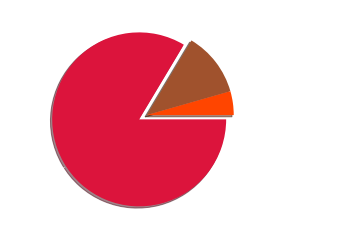

In [10]:
labels = df.stops.value_counts().keys()
values = df.stops.value_counts().values

plt.pie(values,
        labels=labels,
        explode=(0.1, 0, 0),
        shadow=True,
        autopct='%1.2f%%',
        pctdistance=1.2,
        labeldistance=1.5,
        radius=1,
        colors=['crimson', 'sienna', 'orangered'],
        counterclock=False,
        textprops={'color': 'white'})  # Set text color to white

plt.show()


A substantial number of flights had only one stop.

In [11]:
src_city_cnts = df.source_city.value_counts()
src_city_cnts = pd.DataFrame(src_city_cnts).reset_index()
src_city_cnts.columns = ['city','count']
src_city_cnts

,city,count
0,Delhi,61343
1,Mumbai,60896
2,Bangalore,52061
3,Kolkata,46347
4,Hyderabad,40806
5,Chennai,38700


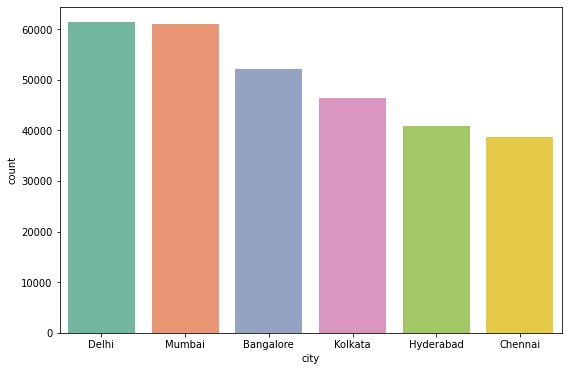

6205

In [12]:
plt.figure(figsize=(9,6))
fig = sns.barplot(x='city',y='count',data=src_city_cnts,palette='Set2')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Most of the flights originate from either Delhi or Mumbai.

In [13]:
dest_city_cnts = df.destination_city.value_counts()
dest_city_cnts = pd.DataFrame(dest_city_cnts).reset_index()
dest_city_cnts.columns = ['city','count']
dest_city_cnts

,city,count
0,Mumbai,59097
1,Delhi,57360
2,Bangalore,51068
3,Kolkata,49534
4,Hyderabad,42726
5,Chennai,40368


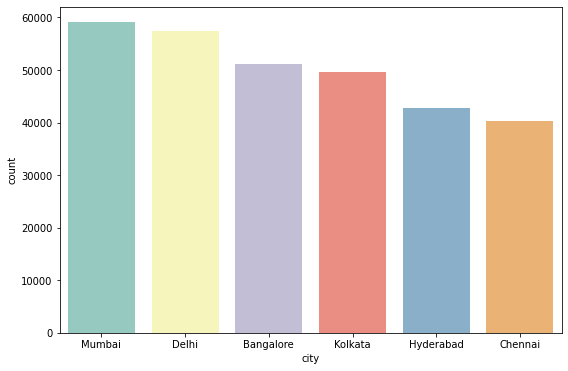

3525

In [14]:
plt.figure(figsize=(9,6))
fig = sns.barplot(x='city',y='count',data=dest_city_cnts,palette='Set3')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

Likewise, Mumbai and Delhi are the most commonly visited cities in India with a considerable number of flights having either of these 2 cities as their destination.

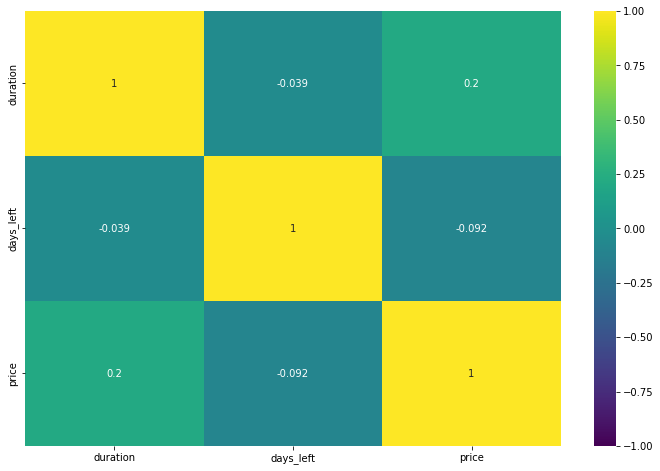

5416

In [15]:
plt.figure(figsize=(12,8))
fig = sns.heatmap(df.corr(),annot=True,cmap='viridis',vmin=-1.0,vmax=1.0)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

## Feature Engineering

### Categorical Encoding

In [16]:
src_city_encoder = OneHotEncoder(drop='first',sparse_output=False,max_categories=10,dtype=np.int64)
src_city_encoded = src_city_encoder.fit_transform(df[['source_city']])
src_city_encoded = pd.DataFrame(src_city_encoded,columns=src_city_encoder.get_feature_names_out())
src_city_encoded

,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
300148,1,0,0,0,0
300149,1,0,0,0,0
300150,1,0,0,0,0
300151,1,0,0,0,0


In [17]:
df = pd.concat([df,src_city_encoded],axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,0,1,0,0,0
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,0,1,0,0,0
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,0,1,0,0,0
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,0,1,0,0,0
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,0,1,0,0,0


In [18]:
dest_city_encoder = OneHotEncoder(drop='first',sparse_output=False,max_categories=10,dtype=np.int64)
dest_city_encoded = dest_city_encoder.fit_transform(df[['destination_city']])
dest_city_encoded = pd.DataFrame(dest_city_encoded,columns=dest_city_encoder.get_feature_names_out())
dest_city_encoded

,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
300148,0,0,1,0,0
300149,0,0,1,0,0
300150,0,0,1,0,0
300151,0,0,1,0,0


In [19]:
df = pd.concat([df,dest_city_encoded],axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,...,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,...,0,1,0,0,0,0,0,0,0,1
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,...,0,1,0,0,0,0,0,0,0,1
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,...,0,1,0,0,0,0,0,0,0,1
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,...,0,1,0,0,0,0,0,0,0,1
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,...,0,1,0,0,0,0,0,0,0,1


In [20]:
df.drop(['source_city','destination_city'],axis=1,inplace=True)

In [21]:
flight_encoder = OneHotEncoder(drop='first',sparse_output=False,dtype=np.int64,max_categories=10)
flights_encoded = flight_encoder.fit_transform(df[['flight']])
flights_encoded = pd.DataFrame(flights_encoded,columns=flight_encoder.get_feature_names_out())
flights_encoded.head()

,flight_UK-720,flight_UK-772,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_infrequent_sklearn
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


In [22]:
df = pd.concat([df,flights_encoded],axis=1)
df.head()

,airline,flight,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,...,destination_city_Mumbai,flight_UK-720,flight_UK-772,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_infrequent_sklearn
0,SpiceJet,SG-8709,Evening,zero,Night,Economy,2.17,1,5953,0,...,1,0,0,0,0,0,0,0,0,1
1,SpiceJet,SG-8157,Early_Morning,zero,Morning,Economy,2.33,1,5953,0,...,1,0,0,0,0,0,0,0,0,1
2,AirAsia,I5-764,Early_Morning,zero,Early_Morning,Economy,2.17,1,5956,0,...,1,0,0,0,0,0,0,0,0,1
3,Vistara,UK-995,Morning,zero,Afternoon,Economy,2.25,1,5955,0,...,1,0,0,0,0,0,0,0,0,1
4,Vistara,UK-963,Morning,zero,Morning,Economy,2.33,1,5955,0,...,1,0,0,0,0,0,0,0,0,1


In [23]:
df.rename({'flight_infrequent_sklearn': 'flight_other'},axis=1,inplace=True)

In [24]:
df.drop('flight',axis=1,inplace=True)

In [25]:
airline_encoder = OneHotEncoder(drop='first',sparse_output=False,dtype=np.int64,max_categories=10)
airlines_encoded = airline_encoder.fit_transform(df[['airline']])
airlines_encoded = pd.DataFrame(airlines_encoded,columns=airline_encoder.get_feature_names_out())
airlines_encoded.head()

,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [26]:
df = pd.concat([df,airlines_encoded],axis=1)
df.head()

,airline,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,...,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_other,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,SpiceJet,Evening,zero,Night,Economy,2.17,1,5953,0,1,...,0,0,0,0,1,0,0,0,1,0
1,SpiceJet,Early_Morning,zero,Morning,Economy,2.33,1,5953,0,1,...,0,0,0,0,1,0,0,0,1,0
2,AirAsia,Early_Morning,zero,Early_Morning,Economy,2.17,1,5956,0,1,...,0,0,0,0,1,0,0,0,0,0
3,Vistara,Morning,zero,Afternoon,Economy,2.25,1,5955,0,1,...,0,0,0,0,1,0,0,0,0,1
4,Vistara,Morning,zero,Morning,Economy,2.33,1,5955,0,1,...,0,0,0,0,1,0,0,0,0,1


In [27]:
df.drop('airline',axis=1,inplace=True)

In [28]:
df.arrival_time.unique()

array(['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening',
       'Late_Night'], dtype=object)

In [29]:
df.departure_time.unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [30]:
df.stops.unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [31]:
df['class'].unique()

array(['Economy', 'Business'], dtype=object)

In [32]:
ohe = OrdinalEncoder(categories=[['zero','one','two_or_more'],['Early_Morning','Morning','Afternoon','Evening','Night','Late_Night'],['Early_Morning','Morning','Afternoon','Evening','Night','Late_Night'],['Economy','Business']])
df[['stops','arrival_time','departure_time','class']] = ohe.fit_transform(df[['stops','arrival_time','departure_time','class']])
df.head()

,departure_time,stops,arrival_time,class,duration,days_left,price,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,...,flight_UK-828,flight_UK-832,flight_UK-836,flight_UK-874,flight_other,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
0,3.0,0.0,4.0,0.0,2.17,1,5953,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0.0,0.0,1.0,0.0,2.33,1,5953,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,0.0,0.0,0.0,2.17,1,5956,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,0.0,2.0,0.0,2.25,1,5955,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,1.0,0.0,1.0,0.0,2.33,1,5955,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [33]:
ohe.categories_

[array(['zero', 'one', 'two_or_more'], dtype=object),
 array(['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night',
        'Late_Night'], dtype=object),
 array(['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night',
        'Late_Night'], dtype=object),
 array(['Economy', 'Business'], dtype=object)]

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   departure_time              300153 non-null  float64
 1   stops                       300153 non-null  float64
 2   arrival_time                300153 non-null  float64
 3   class                       300153 non-null  float64
 4   duration                    300153 non-null  float64
 5   days_left                   300153 non-null  int64  
 6   price                       300153 non-null  int64  
 7   source_city_Chennai         300153 non-null  int64  
 8   source_city_Delhi           300153 non-null  int64  
 9   source_city_Hyderabad       300153 non-null  int64  
 10  source_city_Kolkata         300153 non-null  int64  
 11  source_city_Mumbai          300153 non-null  int64  
 12  destination_city_Chennai    300153 non-null  int64  
 13  destination_ci

### Outlier Treatment

In [35]:
winsorizer = Winsorizer(capping_method='iqr',tail='both',fold=1.5)
skewed_cols = ['duration']
for col in skewed_cols:
    df[col] = winsorizer.fit_transform(df[[col]])

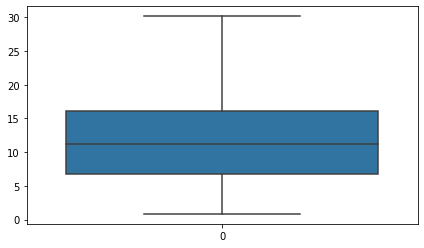

In [36]:
plt.figure(figsize=(7,4))

for col in skewed_cols:
    sns.boxplot(df[col])
    plt.show()

### Feature Splitting

In [37]:
X = df.drop('price',axis=1)
y = df.price

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=50,shuffle=True)

In [39]:
X_train.shape, X_test.shape

((210107, 30), (90046, 30))

In [40]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

### Feature Selection

In [41]:
kbest = SelectKBest(k=10,score_func=f_regression)
kbest.fit(X_train,y_train)

SelectKBest(score_func=<function f_regression at 0x00000137A2523E50>)

In [42]:
selected_features = kbest.get_feature_names_out()
selected_features

array(['stops', 'class', 'duration', 'days_left', 'flight_other',
       'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo',
       'airline_SpiceJet', 'airline_Vistara'], dtype=object)

In [43]:
perc = SelectPercentile(percentile=35,score_func=f_regression)
perc.fit(X_train,y_train)

SelectPercentile(percentile=35,
                 score_func=<function f_regression at 0x00000137A2523E50>)

In [44]:
selected_features = perc.get_feature_names_out()
selected_features

array(['stops', 'class', 'duration', 'days_left', 'flight_UK-772',
       'flight_other', 'airline_Air_India', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara'],
      dtype=object)

In [45]:
lasso = SelectFromModel(estimator=Lasso(),max_features=10)
lasso.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(), max_features=10)

In [46]:
selected_features = lasso.get_feature_names_out()
selected_features

array(['stops', 'class', 'flight_UK-822', 'flight_UK-826',
       'flight_UK-828', 'flight_UK-874', 'airline_GO_FIRST',
       'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara'],
      dtype=object)

In [47]:
rf = SelectFromModel(estimator=RandomForestRegressor(),max_features=10)
rf.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestRegressor(), max_features=10)

In [48]:
selected_features = rf.get_feature_names_out()
selected_features

array(['class', 'duration'], dtype=object)

In [49]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
def plot_feature_importances(feat_imp_type):
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())
    values = list(feat_imps.values())
    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
    fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df,orient='horizontal',palette='viridis')
    plt.title(f"{feat_imp_type.title()} Feature Importance")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect();

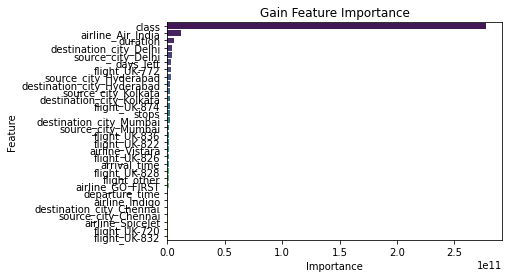

In [51]:
plot_feature_importances('gain')

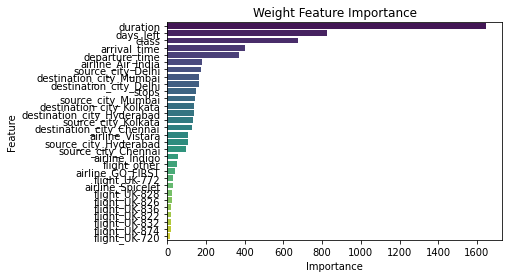

In [52]:
plot_feature_importances('weight')

In [53]:
final_selected_features = ['stops',
                           'class',
                           'duration',
                           'days_left',
                           'airline_Air_India', 
                           'airline_GO_FIRST',
                           'airline_Indigo', 
                           'airline_SpiceJet', 
                           'airline_Vistara',
                           'flight_UK-720',
                           'flight_UK-822',
                           'flight_UK-826',
                           'flight_UK-828', 
                           'flight_UK-874',
                           'arrival_time',
                           'departure_time']
len(final_selected_features)

16

In [54]:
final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]
gc.collect()

0

In [55]:
final_X_train

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_UK-720,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-874,arrival_time,departure_time
265793,1.0,1.0,9.83,27,0,0,0,0,1,0,0,0,0,0,4.0,1.0
80143,1.0,0.0,4.92,22,0,0,1,0,0,0,0,0,0,0,4.0,3.0
30496,1.0,0.0,6.50,16,0,1,0,0,0,0,0,0,0,0,2.0,1.0
169764,1.0,0.0,16.67,41,1,0,0,0,0,0,0,0,0,0,1.0,3.0
290995,1.0,1.0,10.50,12,0,0,0,0,1,0,0,0,0,0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165959,2.0,0.0,9.42,6,0,0,0,0,1,0,0,0,0,0,4.0,1.0
186463,1.0,0.0,9.83,42,0,0,0,1,0,0,0,0,0,0,5.0,2.0
153709,1.0,0.0,7.50,13,0,1,0,0,0,0,0,0,0,0,3.0,1.0
239499,1.0,1.0,24.17,22,0,0,0,0,1,0,0,0,0,0,3.0,3.0


In [56]:
del xgb
gc.collect()

0

### Feature Scaling

In [57]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_UK-720,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-874,arrival_time,departure_time
0,0.191949,1.487315,-0.330549,0.072377,-0.607217,-0.289110,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801
1,0.191949,-0.672353,-1.019531,-0.296257,-0.607217,-0.289110,2.442530,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,0.801078
2,0.191949,-0.672353,-0.797822,-0.738617,-0.607217,3.458897,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-0.517527,-0.611801
3,0.191949,-0.672353,0.629254,1.104552,1.646857,-0.289110,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,0.801078
4,0.191949,1.487315,-0.236534,-1.033524,-0.607217,-0.289110,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801


In [58]:
final_X_test.head()

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_UK-720,flight_UK-822,flight_UK-826,flight_UK-828,flight_UK-874,arrival_time,departure_time
0,0.191949,1.487315,-0.295469,1.030825,-0.607217,-0.28911,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,-0.611801
1,0.191949,-0.672353,-1.218789,-0.148803,-0.607217,-0.28911,2.442530,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,-1.318241
2,0.191949,-0.672353,1.587655,-1.697065,1.646857,-0.28911,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.222411,0.801078
3,0.191949,1.487315,-0.271614,1.473186,1.646857,-0.28911,-0.409412,-0.175687,-0.862195,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,0.962349,0.094638
4,0.191949,1.487315,0.208288,0.883372,-0.607217,-0.28911,-0.409412,-0.175687,1.159830,-0.093968,-0.091778,-0.088614,-0.091752,-0.090075,-1.257466,0.801078


## Model Training & Evaluation

In [59]:
models = []
r2_scores = []
mape_scores = []
rmse_scores = []

In [60]:
final_X_train.drop(final_X_train.columns[final_X_train.columns.duplicated()],axis=1,inplace=True)
final_X_test.drop(final_X_test.columns[final_X_test.columns.duplicated()],axis=1,inplace=True)

In [61]:
def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train)
    y_pred = model.predict(final_X_test)
    r2 = r2_score(y_test,y_pred)
    rmse = mean_squared_error(y_test,y_pred,squared=False)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    print("R2 Score:",r2)
    print("RMSE:",rmse)
    print("MAPE:",mape)
    models.append(model)
    r2_scores.append(r2)
    mape_scores.append(mape)
    rmse_scores.append(rmse)
    gc.collect()
    return model

In [62]:
train_and_evaluate_model(LinearRegression())

R2 Score: 0.9084995671107601
RMSE: 6872.375901366412
MAPE: 0.4240857106973398


LinearRegression()

In [63]:
train_and_evaluate_model(SGDRegressor())

R2 Score: 0.908313978936836
RMSE: 6879.341910033404
MAPE: 0.4244447523947487


SGDRegressor()

In [64]:
train_and_evaluate_model(Lasso())

R2 Score: 0.908499084529032
RMSE: 6872.39402411491
MAPE: 0.4240192018022763


Lasso()

In [65]:
train_and_evaluate_model(KNeighborsRegressor())

R2 Score: 0.9472268827367902
RMSE: 5219.173161268985
MAPE: 0.19750444866764286


KNeighborsRegressor()

In [66]:
train_and_evaluate_model(LinearSVR())

R2 Score: 0.8980472969491562
RMSE: 7254.286511012402
MAPE: 0.2873436769572772


LinearSVR()

In [67]:
train_and_evaluate_model(DecisionTreeRegressor())

R2 Score: 0.9450503039116105
RMSE: 5325.715703823351
MAPE: 0.16990969913168022


DecisionTreeRegressor()

## Baseline Models Performance Comparison

In [68]:
model_perfs = pd.DataFrame({'model': models, 'r2': r2_scores, 'rmse': rmse_scores, 'mape': mape_scores}).sort_values('r2',ascending=False).reset_index()
model_perfs

,index,model,r2,rmse,mape
0,3,KNeighborsRegressor(),0.947227,5219.173161,0.197504
1,5,DecisionTreeRegressor(),0.945050,5325.715704,0.169910
2,0,LinearRegression(),0.908500,6872.375901,0.424086
3,2,Lasso(),0.908499,6872.394024,0.424019
4,1,SGDRegressor(),0.908314,6879.341910,0.424445
5,4,LinearSVR(),0.898047,7254.286511,0.287344


### Pick the best model and pickle it :
> The model with the highest coefficient of determination is 0.947 

In [69]:
import pickle
# Saving model locally.
optimal_model = train_and_evaluate_model(KNeighborsRegressor())
pickle.dump(optimal_model, open('model.pkl','wb'))

R2 Score: 0.9472268827367902
RMSE: 5219.173161268985
MAPE: 0.19750444866764286
